In [1]:
import itertools as it
import time

import heapq
import random

import pandas as pd
import numpy as np
np.random.seed(1337)


dataset_A = pd.read_csv('../TSPA.csv', sep=';', names=['x', 'y', 'cost'])
dataset_B = pd.read_csv('../TSPB.csv', sep=';', names=['x', 'y', 'cost'])

datasets = [dataset_A, dataset_B]

dataset_A.shape, dataset_B.shape

((200, 3), (200, 3))

In [2]:
node1, node2 = dataset_B.iloc[177], dataset_B.iloc[43]

print(f'{node1}\n\n{node2}')

x       1450
y        398
cost      52
Name: 177, dtype: int64

x       1654
y       1486
cost     638
Name: 43, dtype: int64


In [3]:
def euclidean_distance(node1, node2):
    return np.int32(((node1['x'] - node2['x']) ** 2 + (node1['y'] - node2['y']) ** 2) ** 0.5 + 0.5)

In [4]:
print(f'distance between node1 and node2 = {euclidean_distance(node1, node2)}')

distance between node1 and node2 = 1107


In [5]:
def nodes_cost(node1, node2):
    return node1['cost'] + node2['cost']

In [6]:
print(f'objective function of node1 and node2 = {euclidean_distance(node1, node2) + nodes_cost(node1, node2)}')

objective function of node1 and node2 = 1797


In [7]:
def calculate_function_cost(dataset: pd.DataFrame, solution: list) -> int:
    if not solution:
        return 0
    
    cost = 0
    for node in solution:
        cost += dataset.at[node, "cost"]
    
    for i in range(len(solution)):
        node1 = dataset.iloc[solution[i]]
        node2 = dataset.iloc[solution[(i + 1) % len(solution)]]
        cost += euclidean_distance(node1, node2)
    
    return int(cost)

In [8]:
def calculate_distance_matrix(dataset):
    n_nodes = len(dataset)
    distance_matrix = np.zeros((n_nodes, n_nodes), dtype=np.float64)
    for i, j in it.product(range(n_nodes), range(n_nodes)):
        if i == j:
            continue
        a, b = dataset.iloc[i], dataset.iloc[j]
        distance_matrix[i, j] = euclidean_distance(a, b) + nodes_cost(a, b)
    return distance_matrix

In [9]:
distance_matrix_A = calculate_distance_matrix(dataset_A)
distance_matrix_B = calculate_distance_matrix(dataset_B)

In [10]:
print(f'objective function of node1 and node2 = {distance_matrix_A[177, 43]}')

objective function of node1 and node2 = 1831.0


In [11]:
import matplotlib.pyplot as plt

import seaborn as sns

def plot(dataset, solution, title):
    max_x = dataset['x'].max()
    max_y = dataset['y'].max()

    aspect_ratio = int(max_x / max_y)

    if max_x > max_y:
        height = 6.0
        width = height * aspect_ratio
    else:
        width = 6.0
        height = width * aspect_ratio

    sns.set_theme(rc={'figure.figsize': (width, height)})

    sns.scatterplot(
        data=dataset,
        x='x',
        y='y',
        size='cost',
        legend=False
    )

    for i in range(-1, len(solution) - 1):
        idx1 = solution[i]
        idx2 = solution[i + 1]
        x_values = [dataset.loc[idx1, "x"], dataset.loc[idx2, "x"]]
        y_values = [dataset.loc[idx1, "y"], dataset.loc[idx2, "y"]]
        plt.plot(
            x_values,
            y_values,
            color="b",
            linestyle="-",
        )
    

    
    plt.title(title)
    plt.show();

# Local Search



In [12]:
def init_random_solution(dataset: pd.DataFrame, distance_matrix: pd.DataFrame, start: int) -> list:
    selected_count = int(len(dataset) * 0.5 + 0.5)
    return dataset.sample(n=selected_count).index.tolist()

In [13]:
def objective_change_two_nodes(dm: np.ndarray, solution: list, i: int, j: int) -> float:
    if i == j:
        return 0.0

    n = len(solution)
    a, b = solution[i], solution[j]

    a_prev = solution[i - 1] if i > 0 else solution[-1]
    a_next = solution[(i + 1) % n]
    b_prev = solution[j - 1] if j > 0 else solution[-1]
    b_next = solution[(j + 1) % n]

    edges_removed = []
    edges_added = []

    if a_prev not in (a, b):
        edges_removed.append((a_prev, a))
        edges_added.append((a_prev, b))
    if a_next not in (a, b):
        edges_removed.append((a, a_next))
        edges_added.append((b, a_next))
    if b_prev not in (a, b):
        edges_removed.append((b_prev, b))
        edges_added.append((b_prev, a))
    if b_next not in (a, b):
        edges_removed.append((b, b_next))
        edges_added.append((a, b_next))

    delta = -sum(dm[u, v] for u, v in edges_removed) + sum(
        dm[u, v] for u, v in edges_added
    )

    return delta

def objective_change_two_edges(dm: np.ndarray, solution: list, i: int, j: int) -> float:
    if i >= j or (i == 0 and j == len(solution) - 1):
        return 0.0

    n = len(solution)
    a_prev = solution[i - 1] if i > 0 else solution[-1]
    a = solution[i]
    b = solution[j]
    b_next = solution[(j + 1) % n]

    cost_before = dm[a_prev, a] + dm[b, b_next]
    cost_after = dm[a_prev, b] + dm[a, b_next]

    delta = cost_after - cost_before

    return delta

def objective_change_inter_route(
    dm: np.ndarray, solution: list, i: int, vacant_node: int, node_costs: list
) -> float:
    n = len(solution)
    node_in_solution = solution[i]
    prev_node = solution[i - 1] if i > 0 else solution[-1]
    next_node = solution[(i + 1) % n]

    edge_cost_before = dm[prev_node, node_in_solution] + dm[node_in_solution, next_node]
    edge_cost_after = dm[prev_node, vacant_node] + dm[vacant_node, next_node]

    node_cost_before = node_costs[node_in_solution]
    node_cost_after = node_costs[vacant_node]

    delta = (edge_cost_after - node_cost_after) - (edge_cost_before - node_cost_before)

    return delta

In [14]:
def two_nodes_exchange(solution: list, i: int, j: int) -> list:
    new_solution = solution.copy()
    new_solution[i], new_solution[j] = new_solution[j], new_solution[i]
    return new_solution

def two_edges_exchange(solution: list, i: int, j: int) -> list:
    if i >= j:
        return solution.copy()
    new_solution = solution.copy()
    new_solution[i : j + 1] = new_solution[i : j + 1][::-1]
    return new_solution

def inter_route_swap(
    solution: list,
    i: int,
    vacant_node: int,
    selected_nodes: set,
    non_selected_nodes: set,
) -> tuple:
    new_solution = solution.copy()
    node_in_solution = new_solution[i]
    new_solution[i] = vacant_node

    selected_nodes = selected_nodes.copy()
    non_selected_nodes = non_selected_nodes.copy()

    selected_nodes.remove(node_in_solution)
    selected_nodes.add(vacant_node)
    non_selected_nodes.remove(vacant_node)
    non_selected_nodes.add(node_in_solution)

    return new_solution, selected_nodes, non_selected_nodes

In [15]:
def get_remaining_nodes(selected_nodes: set, num_nodes: int) -> set:
    return set(range(num_nodes)) - selected_nodes

In [16]:
def browse_intra_solutions(dm: np.ndarray, solution: list, intra_search: str) -> list:
    intra_neighbors = []
    n = len(solution)
    for i in range(n):
        for j in range(i + 1, n):
            if intra_search == "node":
                delta_nodes = objective_change_two_nodes(dm, solution, i, j)
                if delta_nodes < 0:
                    intra_neighbors.append((i, j, delta_nodes, "node"))
            elif intra_search == "edge":
                delta_edges = objective_change_two_edges(dm, solution, i, j)
                if delta_edges < 0:
                    intra_neighbors.append((i, j, delta_edges, "edge"))
    return intra_neighbors

def browse_inter_solutions(
    dm: np.ndarray, solution: list, non_selected_nodes: set, costs: list
) -> list:
    inter_neighbors = []
    for i in range(len(solution)):
        for vacant_node in non_selected_nodes:
            inter_delta = objective_change_inter_route(
                dm, solution, i, vacant_node, costs
            )
            if inter_delta < 0:
                inter_neighbors.append((i, vacant_node, inter_delta, "inter"))
    return inter_neighbors

In [17]:
def update_solution(
    solution: list,
    best_neighbor: tuple,
    selected_nodes: set,
    non_selected_nodes: set,
) -> tuple:
    neighbor_type = best_neighbor[-1]

    if neighbor_type == "node":
        i, j = best_neighbor[:2]
        solution = two_nodes_exchange(solution, int(i), int(j))
    elif neighbor_type == "edge":
        i, j = best_neighbor[:2]
        solution = two_edges_exchange(solution, int(i), int(j))
    elif neighbor_type == "inter":
        i, vacant_node = best_neighbor[:2]
        solution, selected_nodes, non_selected_nodes = inter_route_swap(
            solution, int(i), int(vacant_node), selected_nodes, non_selected_nodes
        )
    return solution, selected_nodes, non_selected_nodes

In [18]:
def is_move_valid(dataset, solution, move, selected_nodes, non_selected_nodes):
    move_type = move[-1]

    if move_type == "node":
        i, j, delta, _ = move
        # Check indices are in range and nodes exist
        if i >= len(solution) or j >= len(solution):
            return False
        return True
    elif move_type == "edge":
        i, j, delta, _ = move
        if i >= len(solution) or j >= len(solution):
            return False
        return True
    elif move_type == "inter":
        i, vacant_node, delta, _ = move
        if i >= len(solution):
            return False
        # Check if vacant_node is still outside solution
        if vacant_node in solution:
            return False
        return True
    return False

In [19]:
def local_search_with_deltas(
    dataset: pd.DataFrame,
    distance_matrix: np.ndarray,
    initial_solution: list,
    intra_search: str = "edge",
    debug_mode: bool = False
) -> list:
    num_nodes = len(distance_matrix)
    solution = initial_solution.copy()
    selected_nodes = set(solution)
    non_selected_nodes = get_remaining_nodes(selected_nodes, num_nodes)
    costs = dataset["cost"].tolist()

    while True:
        best_move = None
        best_delta = 0

        n = len(solution)
        if intra_search == "edge":
            for i in range(n-1):
                for j in range(i+1, n):
                    delta = objective_change_two_edges(distance_matrix, solution, i, j)
                    if delta < best_delta:
                        best_delta = delta
                        best_move = (i, j, delta, "edge")

        if best_delta == 0:
            for i in range(n):
                node_in_solution = solution[i]
                for vacant_node in non_selected_nodes:
                    delta = objective_change_inter_route(distance_matrix, solution, i, vacant_node, costs)
                    if delta < best_delta:
                        best_delta = delta
                        best_move = (i, vacant_node, delta, "inter")

        if not best_move:
            break

        solution, selected_nodes, non_selected_nodes = update_solution(
            solution, best_move, selected_nodes, non_selected_nodes
        )

    return solution

### MSLS

In [20]:
def MSLS(dataset: pd.DataFrame, distance_matrix: np.ndarray, runs: int = 20) -> tuple:
    # Multiple Start Local Search:
    # 1. Run local search from random solutions 200 times
    # 2. Return the best found solution
    start_time = time.time()
    best_solution = None
    best_cost = float('inf')

    for _ in range(runs):
        initial_solutino = init_random_solution(dataset, distance_matrix, 0)
        local_solution = local_search_with_deltas(
            dataset=dataset,
            distance_matrix=distance_matrix,
            initial_solution=initial_solutino,
            debug_mode=False
        )
        loc_cost = calculate_function_cost(dataset, local_solution)
        if loc_cost < best_cost:
            best_cost = loc_cost
            best_solution = local_solution

    end_time = time.time()
    total_time = end_time - start_time
    return best_solution, best_cost, total_time

### ILS

In [21]:
def perturb_solution(solution: list, exchanges: int = 5) -> list:
    result = solution.copy()
    n = len(solution)
    
    for _ in range(exchanges):
        # Select first segment of 3 consecutive nodes
        start1 = random.randint(0, n - 3)
        seg1 = result[start1:start1 + 3]
        
        # Select second non-overlapping segment
        valid_starts = list(range(0, start1 - 2)) + list(range(start1 + 3, n - 2))
        if not valid_starts:
            continue
            
        start2 = random.choice(valid_starts)
        seg2 = result[start2:start2 + 3]
        
        # Exchange segments
        if start1 < start2:
            result = (
                result[:start1] +
                seg2 +
                result[start1 + 3:start2] +
                seg1 +
                result[start2 + 3:]
            )
        else:
            result = (
                result[:start2] +
                seg1 +
                result[start2 + 3:start1] +
                seg2 +
                result[start1 + 3:]
            )
            
    return result

In [22]:
def ILS(dataset: pd.DataFrame, distance_matrix: np.ndarray, msls_time: float) -> tuple:
    start_time = time.time()
    
    init_sol = init_random_solution(dataset, distance_matrix, 0)
    best_sol = local_search_with_deltas(
        dataset=dataset,
        distance_matrix=distance_matrix,
        initial_solution=init_sol,
        debug_mode=False
    )
    best_cost = calculate_function_cost(dataset, best_sol)
    ls_runs = 1

    while (time.time() - start_time) < msls_time:
        perturbed_sol = perturb_solution(best_sol)
        new_sol = local_search_with_deltas(
            dataset=dataset,
            distance_matrix=distance_matrix,
            initial_solution=perturbed_sol,
            debug_mode=False
        )
        ls_runs += 1
        new_cost = calculate_function_cost(dataset, new_sol)
        if new_cost < best_cost:
            best_cost = new_cost
            best_sol = new_sol.copy()

    return best_sol, best_cost, ls_runs

### Experiments

In [23]:
def run_experiments(dataset: pd.DataFrame, distance_matrix: np.ndarray, title: str, algorithm: str, timeout:int=None, debug_mode: bool=False):
    if algorithm == 'msls':    
        # Run MSLS 20 times
        start_time = time.time()
        msls_results = []
        for i in range(200):
            sol, cost, msls_time = MSLS(dataset, distance_matrix)
            msls_results.append((sol, cost, msls_time))
            
            if debug_mode:
                print(f"Iteration {i}: Cost = {cost}")

        best = min(msls_results, key=lambda x: x[1])
        minimum = best[1]
        mean = sum(obj_function for _, obj_function, _ in msls_results) / len(msls_results)
        maximum = max(msls_results, key=lambda x: x[1])[1]

        end_time = time.time()

        msls_avg_time = ((end_time - start_time) / 200)

        print(f"Best solution: {best[0]}")
        print(f"Time to calculate: {(end_time - start_time):.4f} seconds")
        print(f"Average time to calculate: {msls_avg_time}")
        print("Objective function statistics:")
        print(f"minimum = {minimum}\nmean = {mean}\nmaximum = {maximum}")
        plot(dataset, best[0], title=f"MSLS on {title}")
    
    elif algorithm == "ils":
        # Run ILS 200 times using avg_time of MSLS as the stopping condition
        start_time = time.time()
        ils_results = []
        for i in range(200):
            sol, cost, ls_runs = ILS(dataset, distance_matrix, timeout)
            ils_results.append((sol, cost, ls_runs))

            if debug_mode:
                print(f"Iteration {i}: Cost = {cost}")

        best = min(ils_results, key=lambda x: x[1])
        minimum = best[1]
        mean = sum(obj_function for _, obj_function, _ in ils_results) / len(ils_results)
        maximum = max(ils_results, key=lambda x: x[1])[1]
       
        end_time = time.time()

        ls_runs_values = [ls_runs for _, _, ls_runs in ils_results]

        # Compute statistics for ls_runs
        ls_runs_min = min(ls_runs_values)
        ls_runs_max = max(ls_runs_values)
        ls_runs_mean = sum(ls_runs_values) / len(ls_runs_values)

        print(f"Best solution: {best[0]}")
        print(f"Time to calculate: {(end_time - start_time):.4f} seconds")
        print("Runs statistics:")
        print(f"minimum = {ls_runs_min}\nmean = {ls_runs_mean}\nmax = {ls_runs_max}")
        print("Objective function statistics:")
        print(f"minimum = {minimum}\nmean = {mean}\nmaximum = {maximum}")
        plot(dataset, best[0], title=f"ILS on {title}")

    else:
        print("Invalid algorithm. Choose 'ils' or'msls'.")

Best solution: [116, 65, 131, 149, 59, 118, 51, 151, 133, 162, 123, 127, 70, 135, 154, 180, 53, 100, 26, 86, 75, 101, 1, 97, 152, 2, 120, 44, 25, 16, 171, 175, 113, 56, 31, 78, 145, 92, 129, 57, 55, 52, 178, 106, 185, 165, 119, 40, 196, 81, 90, 27, 164, 7, 21, 144, 14, 49, 102, 62, 9, 15, 148, 124, 94, 63, 79, 80, 176, 137, 23, 186, 89, 183, 143, 0, 117, 93, 68, 46, 115, 139, 41, 193, 159, 69, 108, 18, 22, 146, 181, 34, 160, 54, 177, 10, 190, 184, 42, 43]
Time to calculate: 9207.4120 seconds
Runs statistics:
minimum = 624
mean = 642.54
max = 658
Objective function statistics:
minimum = 69875
mean = 70797.655
maximum = 72440


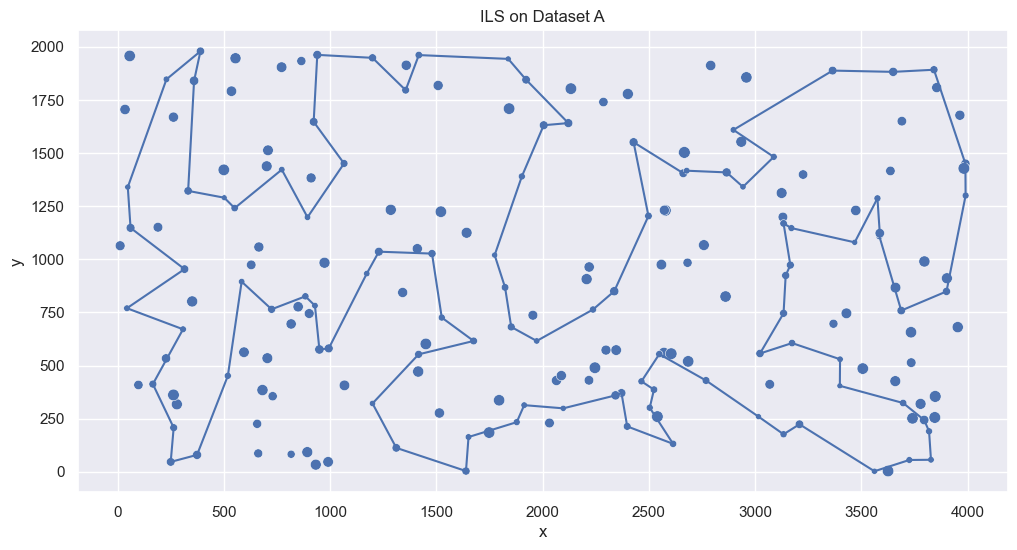

In [24]:
run_experiments(
    dataset=dataset_A,
    distance_matrix=distance_matrix_A,
    title="Dataset A",
    algorithm="ils",
    timeout=46,
)

Best solution: [35, 143, 159, 106, 124, 62, 18, 55, 34, 170, 152, 183, 140, 4, 149, 28, 20, 60, 148, 47, 94, 66, 172, 179, 185, 130, 95, 86, 166, 194, 176, 180, 113, 114, 137, 127, 89, 103, 163, 165, 187, 153, 77, 141, 91, 61, 36, 177, 5, 142, 78, 175, 80, 190, 193, 31, 54, 117, 198, 156, 1, 16, 27, 38, 63, 40, 107, 122, 135, 131, 121, 51, 90, 191, 147, 6, 188, 169, 132, 70, 3, 15, 145, 13, 195, 168, 139, 11, 138, 33, 160, 144, 104, 8, 21, 82, 111, 29, 0, 109]
Time to calculate: 9206.9186 seconds
Runs statistics:
minimum = 593
mean = 645.46
max = 666
Objective function statistics:
minimum = 44070
mean = 45494.965
maximum = 47548


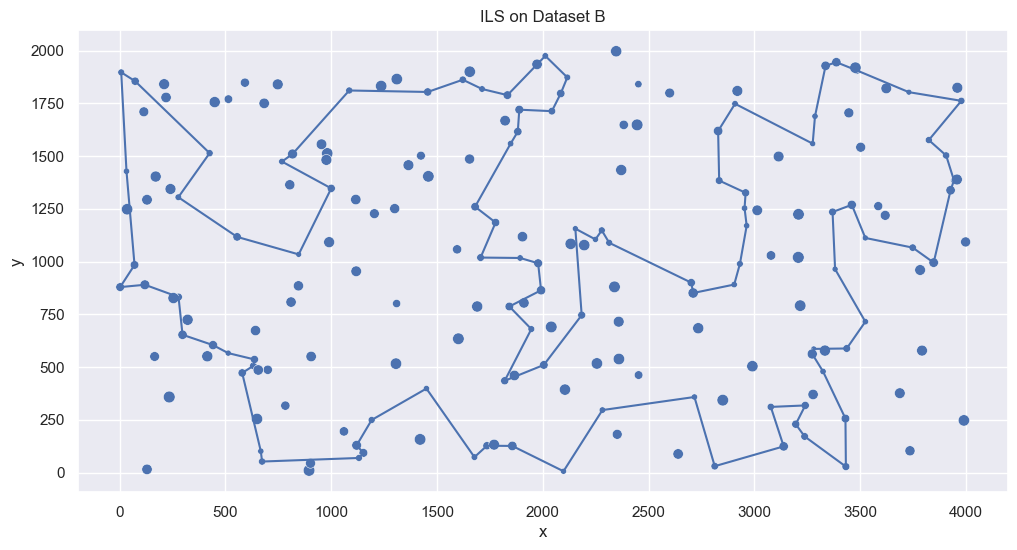

In [25]:
run_experiments(
    dataset=dataset_B,
    distance_matrix=distance_matrix_B,
    title="Dataset B",
    algorithm="ils",
    timeout=46,
)